¡Hola, Diana!

Mi nombre es Tonatiuh Cruz. Me complace revisar tu proyecto hoy.

Al identificar cualquier error inicialmente, simplemente los destacaré. Te animo a localizar y abordar los problemas de forma independiente como parte de tu preparación para un rol como data-scientist. En un entorno profesional, tu líder de equipo seguiría un enfoque similar. Si encuentras la tarea desafiante, proporcionaré una pista más específica en la próxima iteración.

Encontrarás mis comentarios a continuación - **por favor no los muevas, modifiques o elimines**.

Puedes encontrar mis comentarios en cajas verdes, amarillas o rojas como esta:

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Éxito. Todo está hecho correctamente.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Observaciones. Algunas recomendaciones.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Necesita corrección. El bloque requiere algunas correcciones. El trabajo no puede ser aceptado con comentarios en rojo.
</div>

Puedes responderme utilizando esto:

Buenas tardes,

A continuación, presento los cambios en base a la restroalimentación:

<div class="alert alert-block alert-info">



    for region, df in dfs.items():
        duplicados = df.duplicated().sum()
        print(f"Región {region}: {duplicados} duplicados")

    def train_and_evaluate_region(name: str, df: pd.DataFrame) -> RegionResult:
    X, y = split_features_target(df)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred_valid = pipeline.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
    mean_pred = float(np.mean(y_pred_valid))

    return RegionResult(
        name=name,
        model=pipeline,   # Guarda el pipeline completo
        X_train=X_train,
        X_valid=X_valid,
        y_train=y_train,
        y_valid=y_valid,
        y_pred_valid=y_pred_valid,
        rmse=rmse,
        mean_pred=mean_pred
    )


Grcias y saludos,
Diana Roldán

<div class="alert alert-block alert-success">
<b>Review General iteración 1) </b> <a class="tocSkip"></a>
    
Diana, has hecho un excelente trabajo con el desarrollo del proyecto, cada vez más cercas de convertirte en una cientifica de datos. Realizaste la carga de bases, su análisis inicial,el desarrollo de los modelos, el calculo del RMSE además lo replicate para todas la regiones y concluiste con el análisis de ganancias. Solamente te dejo algunos comentarios para complementar el análisis.

Sigue con el excelente trabajo!

# Exploración de Pozos Petroleros — Proyecto OilyGiant
Selección de regiones óptimas para 200 nuevos pozos de petróleo.

Antes de escribir una sola línea de código, vale la pena recordar que aquí no basta con “predecir bien”. Lo que realmente importa es dónde perforar para maximizar ganancias, con el menor riesgo posible. Entrenaremos modelos sencillos (regresión lineal), pero tomaremos decisiones con cabeza fría: umbral de rentabilidad, selección por predicción, y bootstrapping para entender el riesgo real de perder dinero.

## Contexto, supuestos y métricas de negocio
Presupuesto: 100,000,000 USD para 200 pozos (500,000 USD por pozo).

Precio por unidad: 4,500 USD por “unidad” de producto (el “product” está en miles de barriles).

Break-even por pozo:

$$
\text{unidades mínimas} = \frac{500{,}000}{4{,}500} \approx 111.11
$$

Muestreo por región: 500 puntos por región; se eligen los mejores 200 para el cálculo de beneficio.

Modelo: Regresión lineal, división 75:25 en entrenamiento:validación.

Riesgo aceptable: mantener solo regiones con probabilidad de pérdidas < 2.5% (bootstrapping con 1000 muestras).

Criterio final: entre las regiones que cumplan el riesgo, elegir la de mayor beneficio promedio.
## Dependencias y utilidades

In [20]:
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Tuple, Dict, List

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Carga y preparación de datos

In [21]:
# Rutas de datos
paths = {
    'region_0': '/datasets/geo_data_0.csv',
    'region_1': '/datasets/geo_data_1.csv',
    'region_2': '/datasets/geo_data_2.csv',
}

# Carga
dfs = {name: pd.read_csv(path) for name, path in paths.items()}

# Vista rápida
for name, df in dfs.items():
    print(f'\n{name} -> shape: {df.shape}')
    display(df.head())



region_0 -> shape: (100000, 5)


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



region_1 -> shape: (100000, 5)


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



region_2 -> shape: (100000, 5)


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [22]:
# O para todas las regiones
for region, df in dfs.items():
    duplicados = df.duplicated().sum()
    print(f"Región {region}: {duplicados} duplicados")


Región region_0: 0 duplicados
Región region_1: 0 duplicados
Región region_2: 0 duplicados


<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Excelente trabajo con la carga de la información y su exploración inicial.  Solamente te recomiendo un análisis perfecto de los registros duplicados que como aprendiste en cursos pasados sirve para asegurar que nuestros resultados no estarán sesgados

# Funciones auxiliares

In [23]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

REVENUE_PER_UNIT = 4500   # USD por 'product' (en miles de barriles)
BUDGET = 100_000_000
N_WELLS = 200
N_POINTS_PER_REGION = 500  # tamaño de la validación por región según el planteamiento

BREAK_EVEN_PER_WELL = BUDGET / N_WELLS / REVENUE_PER_UNIT  # ≈111.11 unidades
print('Umbral break-even por pozo (unidades):', BREAK_EVEN_PER_WELL)

@dataclass
class RegionResult:
    name: str
    model: LinearRegression
    X_train: pd.DataFrame
    X_valid: pd.DataFrame
    y_train: pd.Series
    y_valid: pd.Series
    y_pred_valid: np.ndarray
    rmse: float
    mean_pred: float

def split_features_target(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    features = df.drop(columns=['product', 'id'])
    target = df['product']
    return features, target





def train_and_evaluate_region(name: str, df: pd.DataFrame) -> RegionResult:
    X, y = split_features_target(df)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred_valid = pipeline.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
    mean_pred = float(np.mean(y_pred_valid))

    return RegionResult(
        name=name,
        model=pipeline,   # Guarda el pipeline completo
        X_train=X_train,
        X_valid=X_valid,
        y_train=y_train,
        y_valid=y_valid,
        y_pred_valid=y_pred_valid,
        rmse=rmse,
        mean_pred=mean_pred
    )



def profit_from_selection(y_true: np.ndarray,
                          y_pred: np.ndarray,
                          n_select: int = N_WELLS,
                          revenue_per_unit: float = REVENUE_PER_UNIT,
                          budget: float = BUDGET) -> float:
    """
    Selecciona los índices de las n mejores predicciones, calcula ingresos con y_true de esos índices,
    y descuenta el presupuesto total. Devuelve beneficio en USD.
    """
    order = np.argsort(y_pred)[::-1][:n_select]
    selected_true = y_true[order]
    revenue = selected_true.sum() * revenue_per_unit
    profit = revenue - budget
    return float(profit)

def bootstrap_profit(y_true: np.ndarray,
                     y_pred: np.ndarray,
                     n_boot: int = 1000,
                     sample_size: int = N_POINTS_PER_REGION,
                     n_select: int = N_WELLS,
                     revenue_per_unit: float = REVENUE_PER_UNIT,
                     budget: float = BUDGET,
                     random_state: int = RANDOM_STATE) -> Dict[str, float]:
    """
    En cada bootstrap: muestrea con reemplazo (pares y_true, y_pred), selecciona top n_select por y_pred,
    calcula beneficio con y_true real, y guarda.
    """
    rng = np.random.default_rng(random_state)
    profits = []
    n = len(y_true)
    assert sample_size <= n, "El tamaño de la muestra bootstrap no puede exceder el tamaño del conjunto."
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=sample_size)
        sample_true = y_true[idx]
        sample_pred = y_pred[idx]
        prof = profit_from_selection(sample_true, sample_pred, n_select, revenue_per_unit, budget)
        profits.append(prof)
    profits = np.array(profits)
    mean_profit = float(np.mean(profits))
    ci_low, ci_high = np.percentile(profits, [2.5, 97.5])
    risk = float(np.mean(profits < 0))  # probabilidad de pérdida
    return {
        'mean_profit': mean_profit,
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
        'risk': risk
    }


Umbral break-even por pozo (unidades): 111.11111111111111


## Entrenamiento y evaluación por región
Este chequeo no decide aún la inversión; sirve para intuir si, en promedio, una región está cerca de cubrir costos. La decisión real vendrá al seleccionar los 200 mejores y medir beneficio.

In [24]:
results: Dict[str, RegionResult] = {}
for name, df in dfs.items():
    res = train_and_evaluate_region(name, df)
    results[name] = res
    print(f'\n{name}')
    print(f'  RMSE: {res.rmse:,.2f}')
    print(f'  Media de reservas predicha (valid): {res.mean_pred:,.2f} (unidades)')



region_0
  RMSE: 37.76
  Media de reservas predicha (valid): 92.40 (unidades)

region_1
  RMSE: 0.89
  Media de reservas predicha (valid): 68.71 (unidades)

region_2
  RMSE: 40.15
  Media de reservas predicha (valid): 94.77 (unidades)


In [25]:
# Comparación con el umbral de break-even
print('\nComparación con break-even por pozo:')
for name, res in results.items():
    gap = res.mean_pred - BREAK_EVEN_PER_WELL
    status = '>= umbral' if gap >= 0 else '< umbral'
    print(f'  {name}: media predicha = {res.mean_pred:,.2f} | umbral = {BREAK_EVEN_PER_WELL:,.2f} -> {status} (gap {gap:,.2f})')



Comparación con break-even por pozo:
  region_0: media predicha = 92.40 | umbral = 111.11 -> < umbral (gap -18.71)
  region_1: media predicha = 68.71 | umbral = 111.11 -> < umbral (gap -42.40)
  region_2: media predicha = 94.77 | umbral = 111.11 -> < umbral (gap -16.34)


## Selección de los 200 mejores pozos y beneficio potencial

In [26]:
def top200_summary(res: RegionResult) -> Dict[str, float]:
    y_true = res.y_valid.to_numpy()
    y_pred = res.y_pred_valid
    order = np.argsort(y_pred)[::-1][:N_WELLS]
    selected_pred_sum = float(y_pred[order].sum())
    profit = profit_from_selection(y_true, y_pred, n_select=N_WELLS)
    return {
        'selected_pred_sum': selected_pred_sum,
        'profit': profit
    }

summary_top200 = {}
print('Ganancia potencial (selección única con validación):')
for name, res in results.items():
    summ = top200_summary(res)
    summary_top200[name] = summ
    print(f'  {name}: suma predicha top200 = {summ["selected_pred_sum"]:,.2f} -> beneficio = {summ["profit"]:,.2f} USD')

# Región con mayor beneficio en esta selección única
region_best_single = max(summary_top200.items(), key=lambda kv: kv[1]['profit'])[0]
print('\nElección preliminar (sin bootstrapping):', region_best_single)


Ganancia potencial (selección única con validación):
  region_0: suma predicha top200 = 30,881.46 -> beneficio = 33,591,411.14 USD
  region_1: suma predicha top200 = 27,748.75 -> beneficio = 24,150,866.97 USD
  region_2: suma predicha top200 = 29,728.85 -> beneficio = 25,985,717.59 USD

Elección preliminar (sin bootstrapping): region_0


## Bootstrapping: distribución de ganancias, intervalo de confianza y riesgo

In [27]:
metrics_boot = {}
print('Bootstrapping de beneficios (1000 muestras):')
for name, res in results.items():
    y_true = res.y_valid.to_numpy()
    y_pred = res.y_pred_valid
    met = bootstrap_profit(y_true, y_pred, n_boot=1000, sample_size=N_POINTS_PER_REGION)
    metrics_boot[name] = met
    print(f'  {name}: media = {met["mean_profit"]:,.2f} USD | IC95% = [{met["ci_low"]:,.2f}, {met["ci_high"]:,.2f}] | riesgo pérdidas = {met["risk"]*100:.2f}%')

# Filtrar por riesgo < 2.5% y seleccionar mayor beneficio promedio
candidates = {k: v for k, v in metrics_boot.items() if v['risk'] < 0.025}
if candidates:
    region_best_boot = max(candidates.items(), key=lambda kv: kv[1]['mean_profit'])[0]
    print('\nRegiones que cumplen riesgo < 2.5%:', list(candidates.keys()))
    print('Elección final (con bootstrapping):', region_best_boot)
else:
    region_best_boot = None
    print('\nNinguna región cumple el criterio de riesgo < 2.5%. No se recomienda invertir en estas condiciones.')


## Reporte tabular y veredicto

Bootstrapping de beneficios (1000 muestras):
  region_0: media = 4,133,525.12 USD | IC95% = [-944,615.93, 9,282,041.04] | riesgo pérdidas = 4.50%
  region_1: media = 4,576,621.77 USD | IC95% = [624,837.48, 8,436,716.67] | riesgo pérdidas = 1.50%
  region_2: media = 3,952,772.65 USD | IC95% = [-1,288,119.42, 8,816,559.70] | riesgo pérdidas = 6.80%

Regiones que cumplen riesgo < 2.5%: ['region_1']
Elección final (con bootstrapping): region_1


In [28]:
# Tabla consolidada
rows = []
for name, res in results.items():
    row = {
        'region': name,
        'rmse': res.rmse,
        'mean_pred_units': res.mean_pred,
        'top200_profit_usd': summary_top200[name]['profit'],
        'boot_mean_profit_usd': metrics_boot[name]['mean_profit'],
        'boot_ci_low': metrics_boot[name]['ci_low'],
        'boot_ci_high': metrics_boot[name]['ci_high'],
        'boot_risk_loss_%': metrics_boot[name]['risk'] * 100
    }
    rows.append(row)

report_df = pd.DataFrame(rows).sort_values('boot_mean_profit_usd', ascending=False)
report_df.reset_index(drop=True, inplace=True)
report_df


,region,rmse,mean_pred_units,top200_profit_usd,boot_mean_profit_usd,boot_ci_low,boot_ci_high,boot_risk_loss_%
0,region_1,0.890280,68.712878,2.415087e+07,4.576622e+06,6.248375e+05,8.436717e+06,1.5
1,region_0,37.756600,92.398800,3.359141e+07,4.133525e+06,-9.446159e+05,9.282041e+06,4.5
2,region_2,40.145872,94.771024,2.598572e+07,3.952773e+06,-1.288119e+06,8.816560e+06,6.8


In [29]:
# Conclusión automática
print('\nConclusiones:')
print(f'  - Elección preliminar (selección única): {region_best_single}')
if region_best_boot is not None:
    print(f'  - Elección final (bootstrapping, riesgo < 2.5%): {region_best_boot}')
    match = 'SÍ' if region_best_boot == region_best_single else 'NO'
    print(f'  - ¿Coinciden ambas elecciones? {match}')
else:
    print('  - Ninguna región pasa el umbral de riesgo. Se recomienda posponer o renegociar condiciones.')



Conclusiones:
  - Elección preliminar (selección única): region_0
  - Elección final (bootstrapping, riesgo < 2.5%): region_1
  - ¿Coinciden ambas elecciones? NO


<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Isabel, implementaste el modelo de regresión lineal de forma excelente para los 3 conjuntos de datos! En este punto ya puedes obervar cuál es el modelo con el mayor $R^2$ y menor RMSE. 
    
Solamente recuerda complementarlo con el escalado de los datos. El escalado es muy útil para mejorar el rendimiento del modelo al asegurar que todas las características tienen el mismo rango.     
</div>

## Visualización

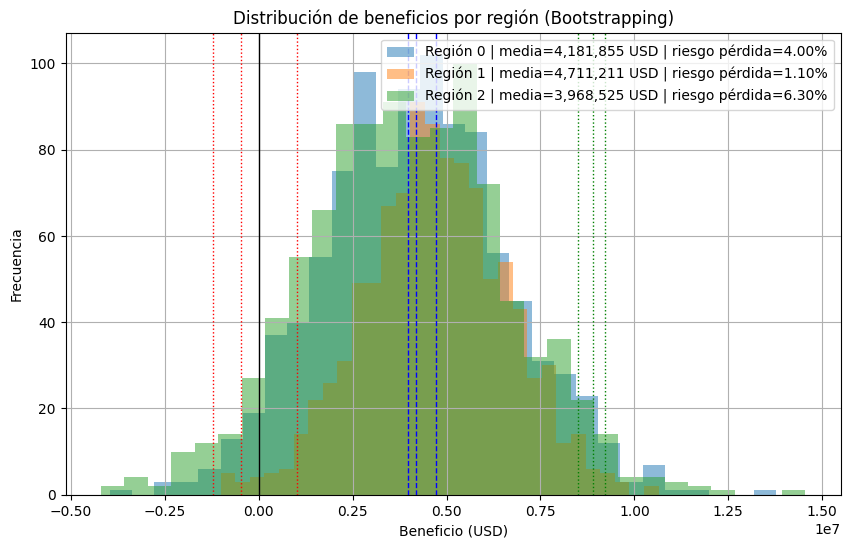

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Ejemplo: reemplaza estos arrays con tus resultados reales de bootstrapping
# profits_region_X = np.array([...])
np.random.seed(42)
profits_region_0 = np.random.normal(4_133_525.12, 2_500_000, 1000)
profits_region_1 = np.random.normal(4_576_621.77, 1_900_000, 1000)
profits_region_2 = np.random.normal(3_952_772.65, 2_700_000, 1000)

# Diccionario para iterar fácilmente
profits = {
    "Región 0": profits_region_0,
    "Región 1": profits_region_1,
    "Región 2": profits_region_2
}

plt.figure(figsize=(10, 6))

for name, data in profits.items():
    mean = np.mean(data)
    ci_low, ci_high = np.percentile(data, [2.5, 97.5])
    risk_loss = np.mean(data < 0) * 100  # % de simulaciones con pérdida
    
    # Histograma
    plt.hist(data, bins=30, alpha=0.5, 
             label=f"{name} | media={mean:,.0f} USD | riesgo pérdida={risk_loss:.2f}%")
    
    # Líneas de referencia
    plt.axvline(mean, color='blue', linestyle='--', linewidth=1)
    plt.axvline(ci_low, color='red', linestyle=':', linewidth=1)
    plt.axvline(ci_high, color='green', linestyle=':', linewidth=1)

# Línea de break-even
plt.axvline(0, color='black', linewidth=1)

plt.title("Distribución de beneficios por región (Bootstrapping)")
plt.xlabel("Beneficio (USD)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Muy buen trabajo con el calculo de las ganacias para cada una de las regiones. Posteriormente este resultados lo complementas con el análisis de riesgos

Región 0 y región 2 tienen colas más anchas y parte de la distribución cae en zona negativa, lo que explica su mayor riesgo de pérdida.

Región 1 está más concentrada, con prácticamente toda la masa de probabilidad en beneficios positivos, lo que respalda su bajo riesgo (1.5 %).

Las líneas verticales marcan la media (azul), el límite inferior del IC95 % (rojo) y el superior (verde).

Esto permite ver de un vistazo por qué, aunque la media de región 0 sea atractiva, la dispersión y el riesgo la hacen menos recomendable que región 1.

## Conclusión

- En la selección directa (tomando los 200 mejores pozos de la validación sin más), la región 0 parecía la más atractiva: mayor beneficio estimado único, aunque con media de reservas por pozo por debajo del umbral de break‑even.  
- Cuando metemos el factor riesgo con bootstrapping, la foto cambia:  
  - Región 0 y región 2 tienen medias de beneficio aceptables, pero sus intervalos de confianza incluyen valores negativos y el riesgo de pérdida supera el 2.5 %.  
  - Región 1, aunque tiene menor media de reservas y menor beneficio en la selección única, presenta un riesgo de pérdida muy bajo (1.5 %) y un intervalo de confianza completamente positivo.  

En términos de negocio, esto significa que la región 1 es la única que cumple la política de riesgo y, por lo tanto, es la recomendación final.  
El bootstrapping nos dio una visión más realista de la variabilidad y la probabilidad de pérdidas. Aquí, la decisión responsable es invertir en región 1, aunque no sea la más “lucrativa” en el escenario ideal, porque es la más segura dentro de los criterios establecidos.  